In [2]:
%cd ..

/home/gianscarpe/dev/event-camera


In [3]:
from experimenting.dataset import DHP3DDataset, get_dataloader
from experimenting.dataset.indexes import get_dataset_params
from experimenting.utils import get_file_paths, decay_heatmap
from matplotlib import pyplot as plt
from os.path import join, basename
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from omegaconf import DictConfig
from experimenting.utils import get_file_paths, get_preload_dir, get_label_from_filename
import cv2

%matplotlib inline

## 

In [4]:
# Augmentation
aug = Compose([ToTensor()])

In [5]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = '/data/dhp19/time_count_dataset/labels'

hparams = DictConfig({'path': data_dir, 'labels_dir' : labels_dir})
file_paths, train_index, val_index, test_index, _ = get_dataset_params(hparams)

LOADED INDEXES! train: 56137 	 val: 14035 	 test: 17543


In [6]:
d = DHP3DDataset(file_paths, labels_dir, train_index, transform=aug)
loader = get_dataloader(d, 32, 2)

In [7]:
def display(img):          
        dst = np.zeros((1, *img.shape[2:]), 'float')
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')  
            dst = cv2.addWeighted(img[i][np.newaxis].astype('float'), .5, dst, .5, 0.0)
        plt.show()
        return dst

In [8]:
batch = next(iter(loader))
x, y = batch

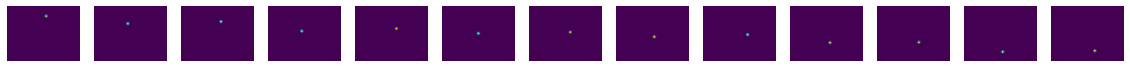

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [9]:
display(y[0].numpy())

## Try Loaded model for 2d heatmap prediction

In [12]:
from experimenting import PoseEstimator as Model
import experimenting.utils as utils
import pytorch_lightning as pl
import os
import experimenting.models.metrics as metrics
mp = metrics.MPJPE()

exp_name = 'exp_Adam_0.0003_center_crop_05-08-09-38_05-08-09-38'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount/exps_PoseEstimator/exps_unet_resnet34/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])

In [18]:
model = Model.load_from_checkpoint(checkpoint_path)

In [19]:
preds = model.forward(x.unsqueeze(0))

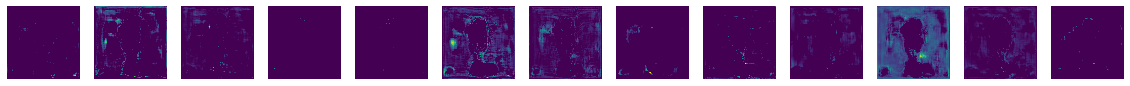

In [20]:
display(preds[0].data)

In [10]:
joints, _ = utils.get_heatmap_max(y.flip(0))

NameError: name 'utils' is not defined

In [13]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

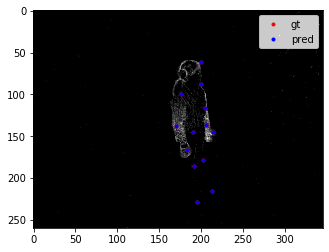

In [20]:
joints, _ = utils.get_heatmap_max(y)
i = 5
plot_2d(x[i].squeeze(), joints[i], joints[i])

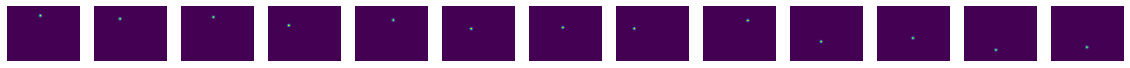

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [293]:
display(y[i].numpy())

In [14]:
# Test

In [73]:
import h5py
import glob

from experimenting.utils import get_heatmap
homedir = '/home/gianscarpe/dev/data/dhp19'
dataset = 'time_count_dataset'  
input_dir = join(homedir, 'labels')    
events_dir = join(homedir, dataset, '346x260')
p_mat_dir = join(homedir, 'P_matrices/')     
out_dir = join('/data/dhp19', 'newlabels')    
width = 344                  
height = 260

In [255]:
p_mat_cam1 = np.load(join(p_mat_dir,'P1.npy'))
p_mat_cam2 = np.load(join(p_mat_dir,'P2.npy'))
p_mat_cam3 = np.load(join(p_mat_dir,'P3.npy'))
p_mat_cam4 = np.load(join(p_mat_dir,'P4.npy'))
p_mats = [p_mat_cam1, p_mat_cam2, p_mat_cam3, p_mat_cam4]

In [177]:
x_paths = sorted(glob.glob(join('/data/dhp19/time_count_dataset/346x260', "*.h5"))) 
y_paths = sorted(glob.glob(join(input_dir, "*.h5")))

'/data/dhp19/time_count_dataset/346x260/S10_session1_mov1_7500events.h5'

In [239]:
x_h5 = h5py.File(x_paths[0], 'r')
y_h5 = h5py.File(y_paths[0], 'r')
frame = 10


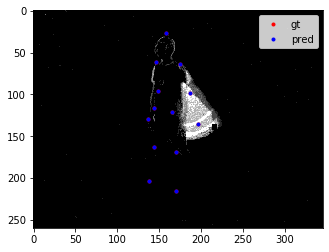

In [268]:
cam = 1
img = np.load(f'/data/dhp19/time_count_dataset/movements_per_frame/S10_session_1_mov_1_frame_{frame}_cam_{3}.npy')
label = y_h5['XYZ'][frame]
vicon, joints, mask, heatmap = get_heatmap(label, p_mats[1], width,
                                                   height)
plot_2d(img, joints, joints)


In [216]:
lab -> frame
0 -> 1
1 -> 3
2 -> 2
3 -> 0


In [271]:
f = get_file_paths(labels_dir, extensions=['npy'])

npy


In [274]:
f[2]

'/data/dhp19/time_count_dataset/labels/S10_session_1_mov_1_frame_0_cam_2_2dhm.npy'

In [281]:
f = get_file_paths(labels_dir, extensions=['npy'])
for x in f:
    if "cam_2" in x:
        continue
    if "cam_0t" in x:
        new_filepath = x.replace("cam_0t", "cam_0")
    if "cam_1t" in x:
        new_filepath = x.replace("cam_1t", "cam_1")
    if "cam_3t" in x:
        new_filepath = x.replace("cam_3t", "cam_3")
    os.rename(x, new_filepath)

npy


In [277]:
'/data/dhp19/time_count_dataset/labels/S10_session_1_mov_1_frame_0_cam_2_2dhm.npy'.replace("cam_2", "cam_1")

'/data/dhp19/time_count_dataset/labels/S10_session_1_mov_1_frame_0_cam_1_2dhm.npy'

In [279]:
f = get_file_paths(labels_dir, extensions=['npy'])

npy


In [280]:
f[9]

'/data/dhp19/time_count_dataset/labels/S10_session_1_mov_1_frame_11_cam_1t_2dhm.npy'

In [303]:
sum([x in '/data/dhp19/time_count_dataset/labels/S10_session_1_mov_1_frame_11_cam_1t_2dhm.npy' for x in ["cam_1", "cam_3"]])

1